In Rasmussen Williams Chapter 5, the authors introduce a Leave-One-Out cross validation (LOOCV) concept for Gaussian Process model selection. Using the partitioned matrix trick, LOOCV has complexity of $\mathcal{O}^3$. The loglikelihood of the validation point $y_i$ is given by

\begin{align*}
\log p(y_i | X, y_{-i}, \theta) & \sim \log \mathcal{N} (\mu_i, \sigma^2_i)
\end{align*}

Cross validation cannot be used in time series, because we know that the data is not independent. It does not make sense to use past data as validation set set and future data as training set. One validation strategy is to use $t_1, \ldots, t_n$ as training set, $t_{n+1}, \ldots, t_{n+v}$ as validation set, and $t_{n+v+1}, \ldots, t_{n+v+d}$ as test set.

**Question** What is the optimum validation strategy for time series data? Can this be another research question?

Given the training set $(X,y)$ and validation set $\hat{X}, \hat{y}$, the loglikelihood of the validation set is

\begin{align*}
\log p(\hat{y} | X, y, \lambda, \sigma) & \sim  \log\mathcal{N} (\hat{\mu}, \hat{\Sigma}) \\
&= - \frac{1}{2} \log \det \hat{\Sigma} - \frac{1}{2} (\hat{y} - \hat{\mu})^T \Sigma^{-1} (\hat{y} - \hat{\mu})
\end{align*}

where $\hat{\mu}$ and $\hat{\Sigma}$ are obtained from the training set $(X,y)$. We can obtained the optimum parameter by maximizing the loglikelihood from the above equation.

      fun: 76.901574359576401
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.42108547e-06,  -1.27897692e-05])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 42
      nit: 13
   status: 0
  success: True
        x: array([ 14.44820308,   1.5532004 ])


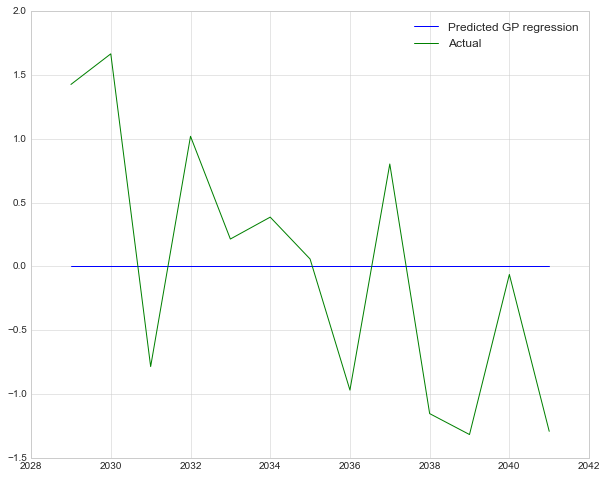

In [4]:
from thesis import data
from thesis import pipeline
from thesis import gp
from thesis import evaluation

from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = 10,8
from matplotlib import style
style.use('seaborn-whitegrid')
%matplotlib inline

weather_data = data.WindData.prefetch_data()
wind_data = data.WindData('2016/1/1',
                          '2016/1/7',
                          '2016/1/8 01:00:00',
                          '2016/1/8 02:00:00',
                          '2016/1/8 00:00:00',
                          '2016/1/8 01:00:00', data=weather_data, scale_y=True)

p = pipeline.Pipeline(data=wind_data,
                      transformer=None,
                      predictor=gp.GaussianProcess(val=True, correction=1),
                      evaluator=[evaluation.mean_square_error])

p.start()

plt.figure(1, figsize=(10,8))
plt.plot(p.data.x_test, p.y_pred[0])
plt.plot(p.data.x_test, p.data.y_test)
plt.legend(['Predicted GP regression', 'Actual'])

The result of the validation is underfitting, although from the regression point of view, the result should give a quite good error since as we can see that the mean of test set y is zero. This might be the result of very large difference in $\hat{y} - \hat{\mu}$ such that the covariance element becomes zero, or there are some problems in the validation implementation. 

Below is another shot of regression of the same data using a GP library [GPy](https://github.com/SheffieldML/GPy). The parameters converge, but it turns out that they also optimize the noise.


Name                              : GP regression
Log-likelihood                    : -2764.14298229
Number of Parameters              : 3
Number of Optimization Parameters : 3
Updates                           : True
Parameters:
  GP_regression.           |  Value  |  Constraint  |  Prior  |  Tied to
  rbf.variance             |    1.0  |     +ve      |         |         
  rbf.lengthscale          |    1.0  |     +ve      |         |         
  Gaussian_noise.variance  |    1.0  |     +ve      |         |         


 /Users/bagas/anaconda/envs/thesis2/lib/python2.7/site-packages/ipykernel/__main__.py:5: DtypeWarning:Columns (6,7,8,9,10,11,12,13,14,32) have mixed types. Specify dtype option on import or set low_memory=False.


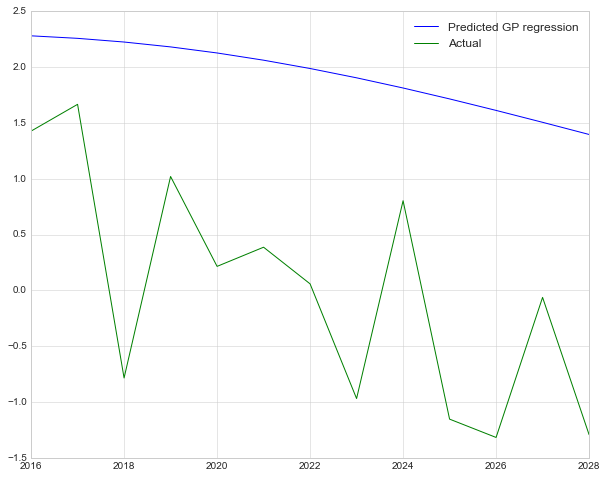

In [8]:
reload(data)
wind_data2 = data.WindData('2016/1/1',
                           '2016/1/7',
                           '2016/1/8 01:00:00',
                           '2016/1/8 02:00:00', None, None, skformat=True, scale_y=True)

p2 = pipeline.Pipeline(data=wind_data2,
                      transformer=None,
                      predictor=gp.GaussianProcessGPy(),
                      evaluator=[evaluation.mean_square_error])

p2.start()
plt.figure(2, figsize=(10,8))
plt.plot(p2.data.x_test, p2.y_pred[0])
plt.plot(p2.data.x_test, p2.data.y_test)
plt.legend(['Predicted GP regression', 'Actual'])

Judging from two above implementations, we can see that the prediction results are still bad. I believe that better feature model is needed, particularly the one that encodes past values. The window technique that you mentioned last week might be a good start. The RNN, which is designed to learn from past information, sounds promising.